### This notebook provides the density of state with Qutip 

$$
 S(\omega) = \int_{-\infty}^{\infty}
        \lim_{t \to \infty} \left<A(t+\tau)B(t)\right>
        e^{-i\omega\tau} d\tau.
$$


$$
\pi A(\omega) = \textrm{Re}\left\{\int_{-\infty}^{\infty}
        \lim_{t \to \infty} \left<A(t+\tau)B(t)\right>
        e^{-i\omega\tau} d\tau \right\}
$$

In [22]:
import contextlib
import dataclasses
import time

import numpy as np
import matplotlib.pyplot as plt

from qutip import *
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver
from IPython.display import display
from ipywidgets import IntProgress

%matplotlib inline

In [23]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [24]:
def state_current(ado_state, bath_tag):
    """ Determine current from the given bath (either "R" or "L") to
        the system in the given ADO state.
    """
    level_1_aux = [
        (ado_state.extract(label), ado_state.exps(label)[0])
        for label in ado_state.filter(level=1, tags=[bath_tag])
    ]

    def exp_sign(exp):
        return 1 if exp.type == exp.types["+"] else -1

    def exp_op(exp):
        return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

    return -1.0j * sum(
        exp_sign(exp) * (exp_op(exp) * aux).tr() for aux, exp in level_1_aux
    )

In [25]:
options = {
    "nsteps": 1500,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

In [26]:
@dataclasses.dataclass
class SystemParameters:
    e1: float = -5  
    U: float = 10  
    Nbos: int = 2

    def __post_init__(self):
        d_up = tensor(destroy(2), qeye(self.Nbos))
        sz = sigmaz()
        d_dn = tensor(-sz, destroy(2))
        self.H = (
            self.e1 * (d_up.dag() * d_up +
            d_dn.dag() * d_dn) +
            self.U * (d_up.dag() * d_up * d_dn.dag() * d_dn)
        )
        self.Q1 = d_up
        self.Q2 = d_dn
        self.Q = d_up + d_dn

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


sys_p = SystemParameters()

In [27]:
from qutip import tensor, destroy, sigmaz

@dataclasses.dataclass
class LorentzianBathParameters:
    lead: str
    Q: object  # coupling operator
    gamma: list = dataclasses.field(default_factory=lambda: [0.0, 0.25, 0.5, 0.75, 1])  # coupling strength
#    gamma: list = dataclasses.field(default_factory=lambda: [2.0, 5.0, 10.0, 50.0, 100])  # coupling strength
    W: float = 10  # cut-off
    T: float = 25E27  # temperature (in eV)
#    T: float = 0.5
    theta: float = 0  # bias

    def __post_init__(self):
        assert self.lead in ("L", "R")
        self.beta = 1 / self.T
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = -self.theta / 2.0

    def J(self, w):
        """ Spectral density. """
        return self.gamma * self.W**2 / ((w - self.mu)**2 + self.W**2)

    def fF(self, w, sign=1.0):
        """ Fermi distribution for this bath. """
        x = sign * self.beta * (w - self.mu)
        return fF(x)

    def lamshift(self, w):
        """ Return the lamb shift. """
        return 0.5 * (w - self.mu) * self.J(w) / self.W

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


def fF(x):
    """ Return the Fermi distribution. """
    # in units where kB = 1.0
    return 1 / (np.exp(x) + 1)


# We set W = 1e4 to investigate the wide-band limit:

d_up = tensor(destroy(2), qeye(2))
sz = sigmaz()
d_dn = tensor(-sz, destroy(2))

# Création des bains pour chaque valeur de gamma
gamma_values = [0.0, 0.25, 0.5, 0.75, 1]

# Bath L et R avec gamma par défaut
bath_L = LorentzianBathParameters(Q=sys_p.Q1, lead="L")
bath_R = LorentzianBathParameters(Q=sys_p.Q2, lead="R")

# Liste de bath_T pour chaque valeur de gamma
bath_T_list = []
for gamma_val in gamma_values:
    bath_T = LorentzianBathParameters(Q=sys_p.Q, lead="L", gamma=gamma_val)
    bath_T_list.append(bath_T)

# Alternative: dictionnaire pour accéder facilement aux bains par valeur de gamma
bath_T_dict = {gamma_val: LorentzianBathParameters(Q=sys_p.Q, lead="L", gamma=gamma_val) 
               for gamma_val in gamma_values}

In [28]:
# Création des opérateurs de collapse pour chaque bath_T
c_ops_list = []
for bath in bath_T_list:
    # Créer les opérateurs de collapse avec la valeur de gamma spécifique à ce bath
    c_ops = [
        np.sqrt(bath.gamma) * d_up,
        np.sqrt(bath.gamma) * d_dn
    ]
    c_ops_list.append(c_ops)

In [29]:
c_ops_dict = {}
for bath in bath_T_list:
    n_th = 1 / (np.exp(SystemParameters.e1 / bath.T) + 1)
    
    c_ops = [
        np.sqrt(bath.gamma * (1 - n_th)) * d_up,
        np.sqrt(bath.gamma * n_th) * d_up.dag(),
        np.sqrt(bath.gamma * (1 - n_th)) * d_dn,
        np.sqrt(bath.gamma * n_th) * d_dn.dag()
    ]
    c_ops_dict[bath.gamma] = c_ops

Calcul du spectre pour gamma = 0.25
Calcul du spectre pour gamma = 0.5
Calcul du spectre pour gamma = 0.75
Calcul du spectre pour gamma = 1


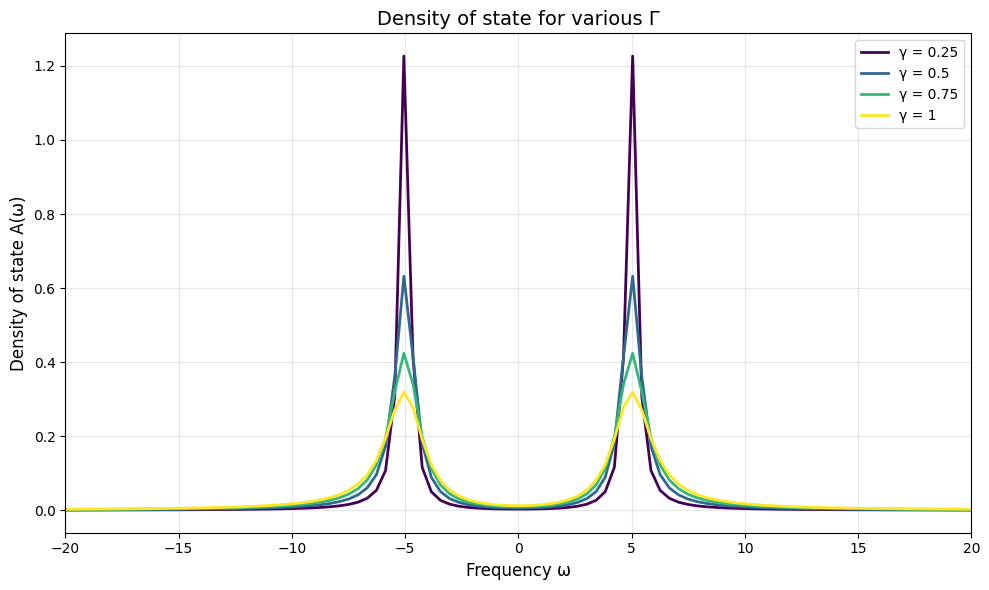

In [30]:
from qutip.solver import spectrum

# Configuration des paramètres
wlist = np.linspace(-20, 20, 100)

# Dictionnaire pour stocker les résultats spectraux pour chaque gamma
spectral_results = {}

# Calcul des spectres pour chaque valeur de gamma
for gamma_val, c_ops in c_ops_dict.items():
    if gamma_val == 0.0:
        continue  # sauter gamma = 0 car sqrt(0) peut causer des problèmes
    
    print(f"Calcul du spectre pour gamma = {gamma_val}")
    
    # Fonction de réponse spectrale Im[G^R(ω)] pour d_up
    S_up = spectrum(sys_p.H, wlist, c_ops, d_up, d_up.dag(), solver='pi')
    
    # Fonction de réponse spectrale pour d_dn
    S_dn = spectrum(sys_p.H, wlist, c_ops, d_dn, d_dn.dag(), solver='pi')
    
    # Densité spectrale totale
    A_w = (np.real(S_up) + np.real(S_dn)) / np.pi
    
    # Stocker les résultats
    spectral_results[gamma_val] = {
        'S_up': S_up,
        'S_dn': S_dn,
        'A_w': A_w
    }

# Tracer toutes les courbes superposées
plt.figure(figsize=(10, 6))

# Couleurs différentes pour chaque gamma
colors = plt.cm.viridis(np.linspace(0, 1, len(spectral_results)))

for i, (gamma_val, results) in enumerate(spectral_results.items()):
    plt.plot(wlist, results['A_w'], 
             label=f'γ = {gamma_val}', 
             color=colors[i],
             linewidth=2)

plt.xlabel('Frequency ω', fontsize=12)
plt.ylabel('Density of state A(ω)', fontsize=12)
plt.title('Density of state for various Γ', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-20, 20)
plt.tight_layout()
plt.savefig('dos_weak_py.png')

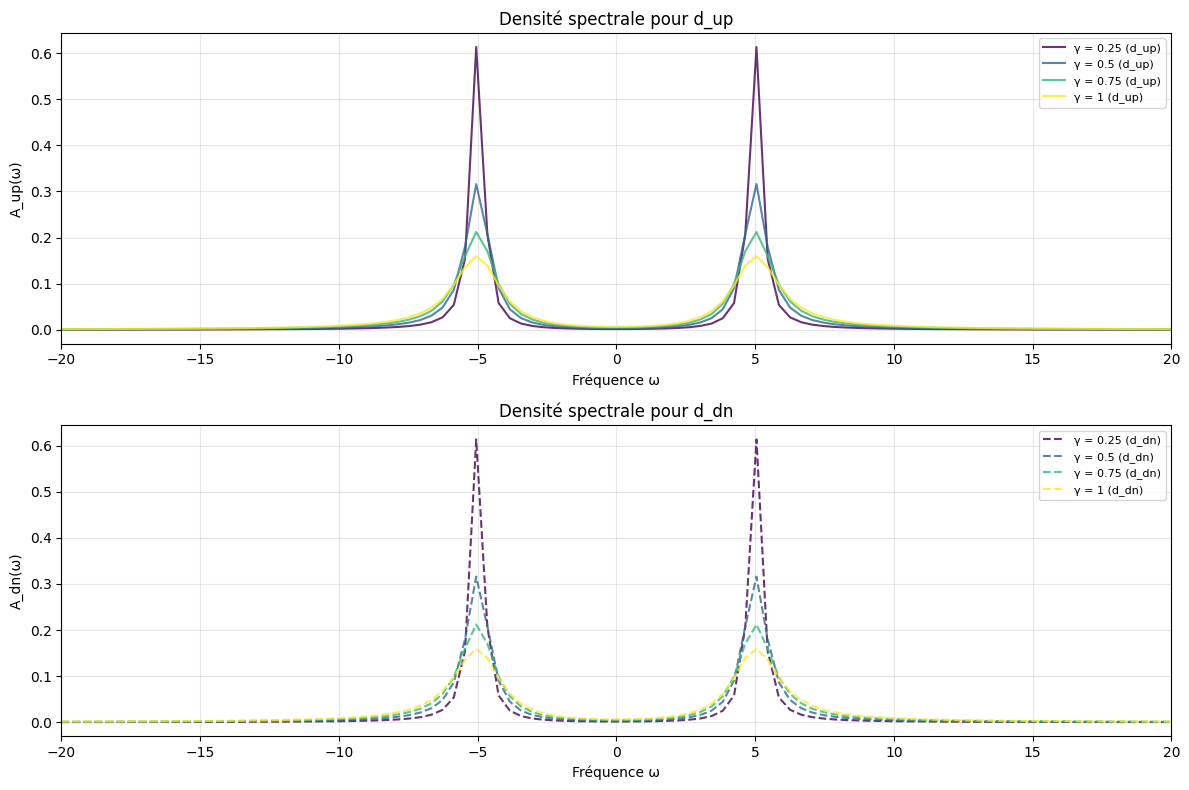

Aperçu des données spectrales:
           w  A_w_gamma_0.25  S_up_gamma_0.25  S_dn_gamma_0.25  A_w_gamma_0.5  \
0 -20.000000        0.000693         0.001088         0.001088       0.001384   
1 -19.595960        0.000726         0.001141         0.001141       0.001451   
2 -19.191919        0.000762         0.001198         0.001198       0.001523   
3 -18.787879        0.000801         0.001259         0.001259       0.001601   
4 -18.383838        0.000844         0.001325         0.001325       0.001685   

   S_up_gamma_0.5  S_dn_gamma_0.5  A_w_gamma_0.75  S_up_gamma_0.75  \
0        0.002174        0.002174        0.002072         0.003254   
1        0.002279        0.002279        0.002172         0.003411   
2        0.002392        0.002392        0.002279         0.003580   
3        0.002514        0.002514        0.002395         0.003762   
4        0.002646        0.002646        0.002520         0.003959   

   S_dn_gamma_0.75  A_w_gamma_1  S_up_gamma_1  S_dn_gamma_1  

In [31]:

# Optionnel: tracer aussi les composantes individuelles
plt.figure(figsize=(12, 8))

for i, (gamma_val, results) in enumerate(spectral_results.items()):
    plt.subplot(2, 1, 1)
    plt.plot(wlist, np.real(results['S_up'])/np.pi, 
             label=f'γ = {gamma_val} (d_up)', 
             color=colors[i],
             linestyle='-',
             alpha=0.8)
    
    plt.subplot(2, 1, 2)
    plt.plot(wlist, np.real(results['S_dn'])/np.pi, 
             label=f'γ = {gamma_val} (d_dn)', 
             color=colors[i],
             linestyle='--',
             alpha=0.8)

plt.subplot(2, 1, 1)
plt.xlabel('Fréquence ω')
plt.ylabel('A_up(ω)')
plt.title('Densité spectrale pour d_up')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.xlim(-20, 20)

plt.subplot(2, 1, 2)
plt.xlabel('Fréquence ω')
plt.ylabel('A_dn(ω)')
plt.title('Densité spectrale pour d_dn')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.xlim(-20, 20)

plt.tight_layout()
plt.show()

# Sauvegarder les données si nécessaire
import pandas as pd

# Créer un DataFrame avec tous les résultats
spectral_data = pd.DataFrame({'w': wlist})
for gamma_val, results in spectral_results.items():
    spectral_data[f'A_w_gamma_{gamma_val}'] = results['A_w']
    spectral_data[f'S_up_gamma_{gamma_val}'] = np.real(results['S_up'])
    spectral_data[f'S_dn_gamma_{gamma_val}'] = np.real(results['S_dn'])

# Afficher un aperçu des données
print("Aperçu des données spectrales:")
print(spectral_data.head())

# Optionnel: sauvegarder en CSV
# spectral_data.to_csv('spectral_density_results.csv', index=False)

In [2]:
import qutip
qutip.__version__

'5.2.2'